## HAAR CASCADE
This notebook present a traditional approach to face detection. HAAR cascade classifier consists of the following steps:

1. Training data creation (positive + negative examples)
2. Extraction of Haar features
3. Adaboost training and most relevant features selection
4. Creation of a Cascade of classifiers 

![Paul Viola and Michael Jones, "Rapid Object Detection using a Boosted Cascade of Simple Features“, 2001](HAAR1.png)
![](HAAR2.png)

In [1]:
import cv2
%matplotlib inline
from matplotlib import pyplot as plt

# base HAAR extractor function. This function reads the image, converts it to grayscale, applies the face finder and 
# returns a vector with list of bbox for faces
def find_face(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5)
    return faces

# same function as above but with extra output (HAAR face extractor input image converted to grayscale)
def find_face_decomposition(image, minNeighbors=5, scaleFactor=1.1):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=scaleFactor, minNeighbors=minNeighbors)
    return gray_img, faces

# function for iterating over different setting of the face finder
def find_face_with_diff_params(path_in):
    import matplotlib.pyplot as plt
    # show random images from train
    cols = 4
    rows = 4
    fig = plt.figure(figsize=(4.5 * cols - 1, 2.5 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            neighbors = (i+1)*3
            scaling = ((j+1)/10+1)

            image = plt.imread(path_in)
            gray_image, faces = find_face_decomposition(image, minNeighbors=neighbors, scaleFactor=scaling)
            for (x, y, w, h) in faces:
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            plt.imshow(image, cmap = "gray")
            ax.set_title("minNeighbors: " + str(neighbors) + " scaleFactor: " + str(scaling))
    plt.show()

## Playing with HAAR parameters

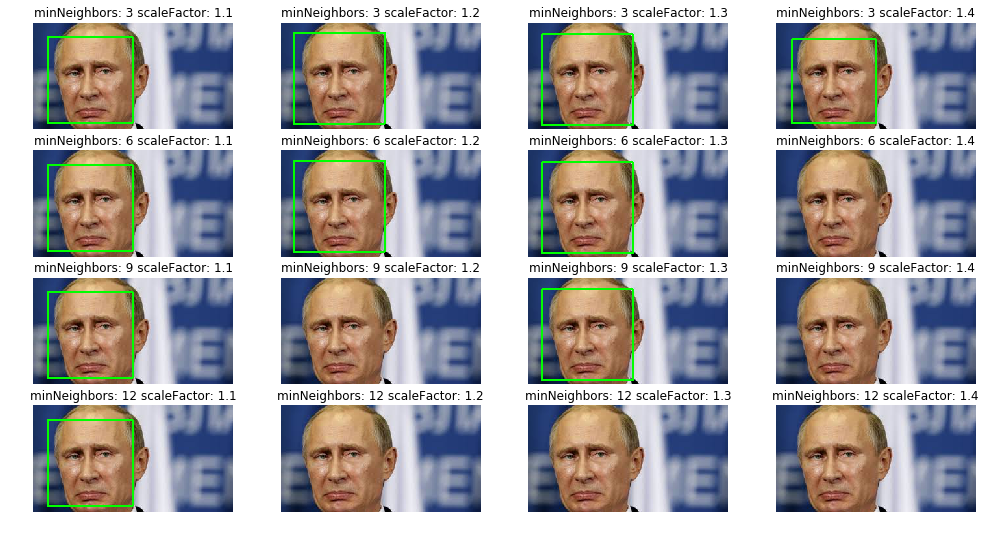

In [2]:
path_in_1 = "../Test data/putin/3.jpg"
find_face_with_diff_params(path_in_1)

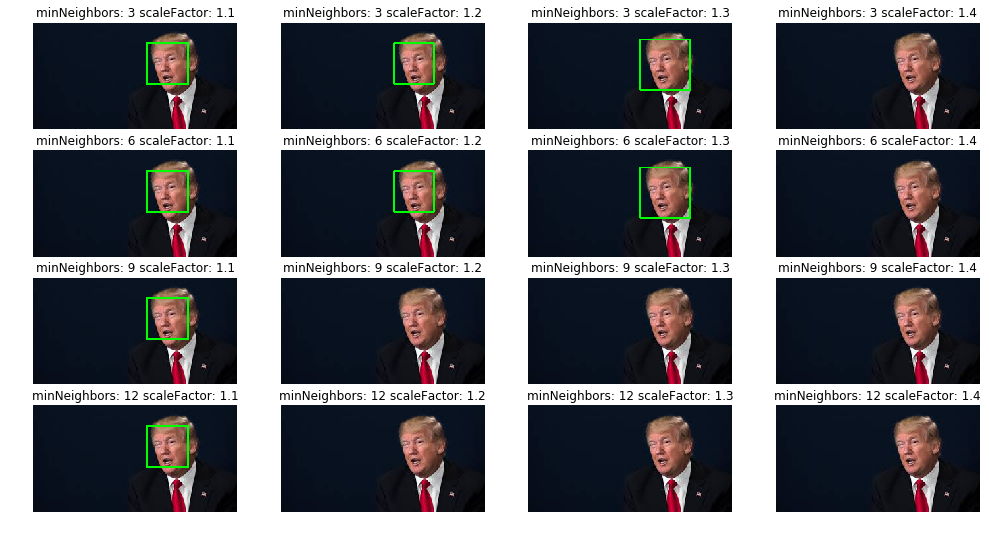

In [3]:
path_in_2 = "../Test data/trump/1.jpg"
find_face_with_diff_params(path_in_2)

## Visualizing HAAR input and output

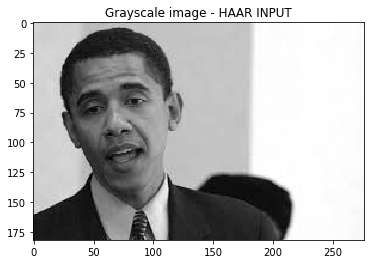

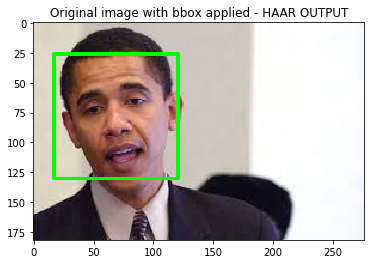

In [4]:
import os
path_in = "../Test data/obama/"
image = plt.imread(os.path.join(path_in,"1.jpg"))
gray_image, faces = find_face_decomposition(image)
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(gray_image, cmap = "gray")
plt.title("Grayscale image - HAAR INPUT")
plt.figure()
plt.imshow(image)
plt.title("Original image with bbox applied - HAAR OUTPUT")

## Experiment

In [5]:
def create_date(path_in, people, path_out):
    for i in people:
        print(i)
        if not os.path.exists(os.path.join(path_out,i)):
            os.makedirs(os.path.join(path_out,i))
        file_list = os.listdir(os.path.join(path_in,i))
        for j in file_list:
            image = plt.imread(os.path.join(path_in,i,j))
            faces = find_face(image)
            for (x, y, w, h) in faces:
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
            plt.imsave(fname = os.path.join(path_out,i,j), 
                       arr = image)

In [6]:
path_in = "../Test data"
path_out = "results2"
people = ['cameron', 'holland', 'merkel', 'neither', 'obama', 'putin', 'trump']

#create_date(path_in, people, path_out)

In [24]:
import pandas as pd
def generate_results(path_in, people):
    result = list()
    person = list()
    name = list()
    location = list()
    for i in people:
        print(i)
        file_list = os.listdir(os.path.join(path_in,i))
        for j in file_list:
            image = plt.imread(os.path.join(path_in,i,j))
            faces = find_face(image)
            result.append(len(faces))
            person.append(i)
            name.append(j)
            location.append(faces)
    df = pd.DataFrame({"person":person, "image":name, "faces_count":result, "location":location})
    return(df)

In [25]:
path_in = "../Test data"
people = ['cameron', 'holland', 'merkel', 'neither', 'obama', 'putin', 'trump']
results = generate_results(path_in, people)

cameron
holland
merkel
neither
obama
putin
trump


In [26]:
results_pivoted = results.pivot_table(values="image", columns="faces_count", index="person", aggfunc="count")
results_pivoted.fillna(value=0)

faces_count,0,1,2,3,4
person,,,,,
cameron,9.0,122.0,4.0,0.0,1.0
holland,8.0,107.0,3.0,0.0,0.0
merkel,16.0,121.0,2.0,1.0,0.0
neither,16.0,97.0,7.0,0.0,1.0
obama,11.0,123.0,7.0,2.0,0.0
putin,26.0,119.0,3.0,0.0,0.0
trump,43.0,98.0,5.0,1.0,0.0


In [11]:
#results.to_csv("results2/results.csv", index=False)
#results_pivoted.to_csv("results2/results_pivoted.csv")

## Visualization of results

In [27]:
def filter_and_visualize(path_in, results, face_count, top_n, person = None):
    df = results[results.faces_count == face_count]
    if person is not None:
        df = df[df.person == person]
    df = df.head(top_n)
    for image in range(df.shape[0]):
        faces = df.loc[df.index[image], "location"]
        image = plt.imread(os.path.join(path_in,
                                        df.loc[df.index[image], "person"],
                                        df.loc[df.index[image], "image"]))
        for bbox in range(len(faces)):
            x,y,w,h = faces[bbox]
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        plt.figure()
        plt.imshow(image)
    return df

,faces_count,image,location,person
0,1,1.jpg,"[[75, 23, 59, 59]]",cameron
1,1,2Q== (1).jpg,"[[115, 38, 90, 90]]",cameron
2,1,2Q== (2).jpg,"[[99, 40, 98, 98]]",cameron
3,1,2Q== (3).jpg,"[[74, 31, 95, 95]]",cameron
4,1,2Q== (4).jpg,"[[115, 38, 90, 90]]",cameron
5,1,2Q== (5).jpg,"[[99, 40, 98, 98]]",cameron
6,1,2Q==.jpg,"[[74, 31, 95, 95]]",cameron
7,1,9k= (1).jpg,"[[96, 15, 59, 59]]",cameron
8,1,9k= (10).jpg,"[[96, 15, 59, 59]]",cameron
9,1,9k= (11).jpg,"[[54, 47, 108, 108]]",cameron


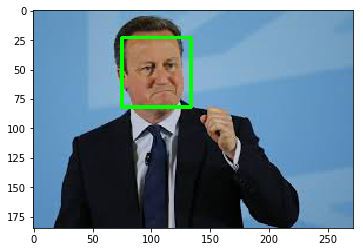

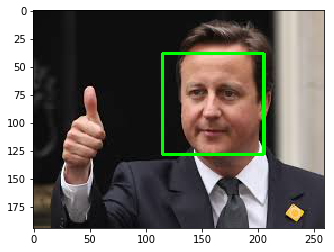

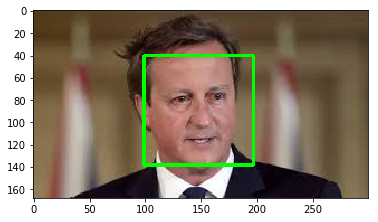

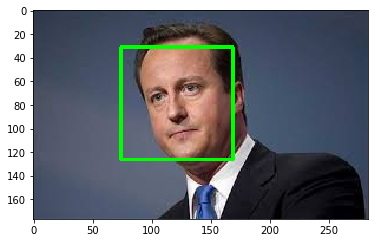

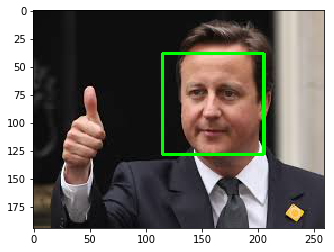

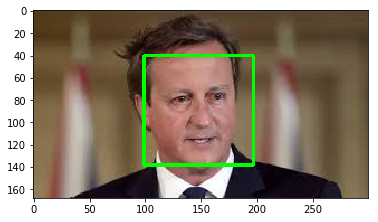

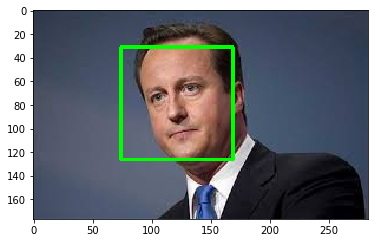

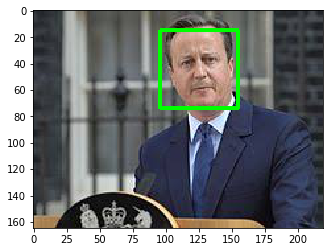

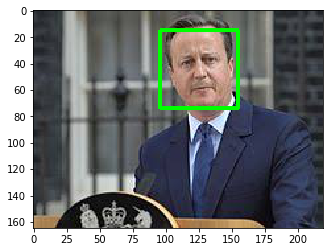

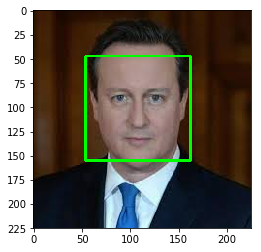

In [28]:
filter_and_visualize(path_in="../Test data", results=results, face_count=1, top_n=10, person=None)

,faces_count,image,location,person
0,1,1.jpg,"[[75, 23, 59, 59]]",cameron
1,1,2Q== (1).jpg,"[[115, 38, 90, 90]]",cameron


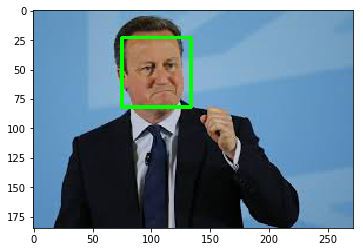

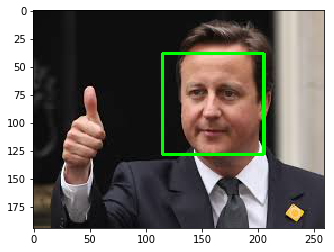

In [29]:
filter_and_visualize(path_in="../Test data", results=results, face_count=1, top_n=2, person="cameron")